# PBS dataset analysis

This notebook aims to assess our model's performances on the dataset PBS. It is applied to the cingulate region.

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import LinearSVC

from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
model_dir = '/neurospin/dico/lguillon/distmap/PBS/runs/right/checkpoint.pt'
model = VAE((1, 80, 88, 104), 75, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Loading of HCP test set

In [4]:
subject_dir = "/neurospin/dico/lguillon/distmap/PBS/data/"
data_dir = "/neurospin/dico/lguillon/distmap/PBS/data/"
test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))
distmaps = np.load(os.path.join(data_dir, "Rtest_distmap.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "Rtest_sub_id.npy"))
print(distmaps.shape, filenames.shape)

subset = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                         data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

(200, 78, 86, 99, 1) (200,)


### Loading of PBS cohort data

In [5]:
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/epilepsy/crops/1mm"
data_path = "SC_precentral/no_mask"

In [7]:
print(os.path.join(data_dir, "controls", data_path, "Rdistmap.npy"))

/neurospin/dico/data/deep_folding/current/datasets/epilepsy/crops/1mm/controls/SC_precentral/no_mask/Rdistmap.npy


In [6]:
controls = np.load(os.path.join(data_dir, "controls", data_path, "Rdistmap.npy"),
                   mmap_mode='r')
filenames_controls = np.load(os.path.join(data_dir, "controls", data_path, "sub_id.npy"))

subset_controls = SkeletonDataset(dataframe=controls,
                                 filenames=filenames_controls,
                                 data_transforms=False)
loader_controls = torch.utils.data.DataLoader(
               subset_controls,
               batch_size=1,
               num_workers=1,
               shuffle=False)

pbs_sub_neg = np.load(os.path.join(data_dir, "irm_negatives_centrales", data_path, "Rdistmap.npy"),
                   mmap_mode='r')
filenames_pbs_sub_neg = np.load(os.path.join(data_dir, "irm_negatives_centrales", data_path, "sub_id.npy"))

subset_pbs_sub_neg = SkeletonDataset(dataframe=pbs_sub_neg,
                             filenames=filenames_pbs_sub_neg,
                             data_transforms=False)
loader_pbs_sub_neg = torch.utils.data.DataLoader(
                       subset_pbs_sub_neg,
                       batch_size=1,
                       num_workers=1,
                       shuffle=False)

pbs_sub_pos = np.load(os.path.join(data_dir, "irm_positives_centrales", data_path, "Rdistmap.npy"),
                   mmap_mode='r')
filenames_pbs_sub_pos = np.load(os.path.join(data_dir, "irm_positives_centrales", data_path, "sub_id.npy"))

subset_pbs_sub_pos = SkeletonDataset(dataframe=pbs_sub_pos,
                             filenames=filenames_pbs_sub_pos,
                             data_transforms=False)
loader_pbs_sub_pos = torch.utils.data.DataLoader(
                       subset_pbs_sub_pos,
                       batch_size=1,
                       num_workers=1,
                       shuffle=False)

In [7]:
dico_set_loaders = {'hcp_test': testloader, 
                    'controls': loader_controls, 
                    'pbs_sub_neg': loader_pbs_sub_neg,
                    'pbs_sub_pos': loader_pbs_sub_pos}

root_dir = '/neurospin/dico/lguillon/distmap/PBS/results/'

criterion = nn.MSELoss(reduction='sum')
tester_deletion = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
var_deletion = {loader_name:[results_deletion[loader_name][k][4] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

hcp_test
[0.0000000e+00 2.8610229e-06 5.2452087e-06 ... 9.9935913e-01 9.9955142e-01
 9.9988782e-01]
[0.0000000e+00 9.2983246e-06 1.0251999e-05 ... 9.9965823e-01 9.9975324e-01
 9.9990916e-01]
[0.0000000e+00 1.7642975e-05 2.4557114e-05 ... 9.9978638e-01 9.9981844e-01
 9.9998927e-01]
[0.0000000e+00 2.3841858e-05 2.6464462e-05 ... 9.9871826e-01 9.9910271e-01
 9.9964750e-01]
[0.0000000e+00 2.0742416e-05 2.4557114e-05 ... 9.9956739e-01 9.9971688e-01
 9.9996638e-01]
[0.0000000e+00 4.0531158e-06 6.4373016e-06 ... 9.9903870e-01 9.9962616e-01
 9.9966884e-01]
[0.00000000e+00 1.01327896e-04 1.15871429e-04 ... 9.99765038e-01
 9.99781013e-01 9.99851823e-01]
[0.0000000e+00 2.6226044e-06 2.8610229e-06 ... 9.9955142e-01 9.9966359e-01
 9.9985051e-01]
[0.0000000e+00 1.3113022e-05 1.7404556e-05 ... 9.9941719e-01 9.9955666e-01
 9.9983978e-01]
[0.0000000e+00 1.3113022e-05 1.9073486e-05 ... 9.9977577e-01 9.9984956e-01
 9.9996257e-01]
[0.0000000e+00 2.8133392e-05 2.8371811e-05 ... 9.9944460e-01 9.9955511e-01


[0.0000000e+00 2.5987625e-05 2.6941299e-05 ... 9.9959946e-01 9.9969554e-01
 9.9982381e-01]
[0.0000000e+00 4.7922134e-05 5.1498413e-05 ... 9.9945533e-01 9.9982917e-01
 9.9998391e-01]
[0.0000000e+00 5.0067902e-06 5.4836273e-06 ... 9.9970090e-01 9.9971163e-01
 9.9980247e-01]
[0.0000000e+00 5.9604645e-06 6.1988831e-06 ... 9.9964750e-01 9.9981844e-01
 9.9989319e-01]
[0.0000000e+00 5.8889389e-05 7.9631805e-05 ... 9.9933863e-01 9.9944985e-01
 9.9967957e-01]
[0.0000000e+00 2.3841858e-06 2.6226044e-06 ... 9.9954069e-01 9.9977160e-01
 9.9980772e-01]
[0.0000000e+00 7.4863434e-05 7.9393387e-05 ... 9.9988782e-01 9.9996793e-01
 9.9998927e-01]
[0.0000000e+00 2.1934509e-05 2.4557114e-05 ... 9.9950862e-01 9.9969029e-01
 9.9995029e-01]
[0.0000000e+00 1.4305115e-06 1.9073486e-06 ... 9.9949265e-01 9.9967957e-01
 9.9984515e-01]
[0.0000000e+00 2.6464462e-05 2.8133392e-05 ... 9.9985051e-01 9.9991453e-01
 9.9999464e-01]
[0.0000000e+00 2.6941299e-05 3.0040741e-05 ... 9.9957812e-01 9.9965823e-01
 9.9969029e-01]

[0.0000000e+00 6.1511993e-05 7.4863434e-05 ... 9.9977577e-01 9.9979711e-01
 9.9990392e-01]
[0.0000000e+00 2.3365021e-05 3.0994415e-05 ... 9.9978638e-01 9.9988782e-01
 9.9989319e-01]
[0.000000e+00 9.536743e-06 1.001358e-05 ... 9.994339e-01 9.997330e-01
 9.998025e-01]
[0.0000000e+00 2.6226044e-06 3.5762787e-06 ... 9.9959946e-01 9.9986112e-01
 9.9987185e-01]
[0.0000000e+00 3.1232834e-05 3.1471252e-05 ... 9.9889672e-01 9.9986112e-01
 9.9992526e-01]
[0.0000000e+00 3.1709671e-05 3.2424927e-05 ... 9.9982381e-01 9.9983442e-01
 9.9998415e-01]
[0.0000000e+00 1.2874603e-05 1.7166138e-05 ... 9.9952567e-01 9.9968493e-01
 9.9981844e-01]
[0.0000000e+00 8.3446503e-06 1.1205673e-05 ... 9.9963152e-01 9.9964750e-01
 9.9968493e-01]
[0.0000000e+00 5.7220459e-06 6.6757202e-06 ... 9.9948204e-01 9.9953532e-01
 9.9960887e-01]
[0.0000000e+00 9.5367432e-06 1.0728836e-05 ... 9.9973297e-01 9.9973822e-01
 9.9982917e-01]
[0.0000000e+00 1.2397766e-05 1.5258789e-05 ... 9.9944985e-01 9.9962616e-01
 9.9982917e-01]
[0.00

In [8]:
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded_deletion['hcp_test'] +encoded_deletion['controls']+ encoded_deletion['pbs_sub_neg'] + encoded_deletion['pbs_sub_pos']
df_encoded['loss'] = losses_deletion['hcp_test'] + losses_deletion['controls'] + losses_deletion['pbs_sub_neg'] + losses_deletion['pbs_sub_pos']
df_encoded['recon'] = recon_deletion['hcp_test'] + recon_deletion['controls'] +recon_deletion['pbs_sub_neg'] +recon_deletion['pbs_sub_pos']
df_encoded['input'] = input_deletion['hcp_test'] + input_deletion['controls'] + input_deletion['pbs_sub_neg'] + input_deletion['pbs_sub_pos']
df_encoded['sub'] = list(filenames) + list(filenames_controls) + list(filenames_pbs_sub_neg) + list(filenames_pbs_sub_pos) 
df_encoded['group'] = ['hcp_test' for k in range(len(list(filenames)))] + ['controls' for k in range(len(list(filenames_controls)))] + ['pbs_sub_neg' for k in range(len(list(filenames_pbs_sub_neg)))] + ['pbs_sub_pos' for k in range(len(list(filenames_pbs_sub_pos)))] 

In [9]:
deletion_hcp = pd.DataFrame()
deletion_hcp['latent'] = encoded_deletion['hcp_test']
deletion_hcp['loss'] = losses_deletion['hcp_test']  
deletion_hcp['recon'] = recon_deletion['hcp_test']   
deletion_hcp['input'] = input_deletion['hcp_test'] 
deletion_hcp['sub'] = list(filenames) 

In [10]:
deletion_controls = pd.DataFrame()
deletion_controls['latent'] = encoded_deletion['controls']
deletion_controls['loss'] = losses_deletion['controls']  
deletion_controls['recon'] = recon_deletion['controls']   
deletion_controls['input'] = input_deletion['controls'] 
deletion_controls['sub'] = list(filenames_controls) 

In [11]:
deletion_pbs_sub_neg = pd.DataFrame()
deletion_pbs_sub_neg['latent'] = encoded_deletion['pbs_sub_neg']
deletion_pbs_sub_neg['loss'] = losses_deletion['pbs_sub_neg']  
deletion_pbs_sub_neg['recon'] = recon_deletion['pbs_sub_neg']   
deletion_pbs_sub_neg['input'] = input_deletion['pbs_sub_neg'] 
deletion_pbs_sub_neg['sub'] = list(filenames_pbs_sub_neg) 

In [12]:
deletion_pbs_sub_pos = pd.DataFrame()
deletion_pbs_sub_pos['latent'] = encoded_deletion['pbs_sub_pos']
deletion_pbs_sub_pos['loss'] = losses_deletion['pbs_sub_pos']  
deletion_pbs_sub_pos['recon'] = recon_deletion['pbs_sub_pos']   
deletion_pbs_sub_pos['input'] = input_deletion['pbs_sub_pos'] 
deletion_pbs_sub_pos['sub'] = list(filenames_pbs_sub_pos) 

### L_{D} metric computation

In [15]:
data_dir = '/neurospin/dico/lguillon/distmap/PBS/data/'
filenames_all = np.load(os.path.join(data_dir,
                                "Rtrain_sub_id.npy"))
distmaps = np.load(os.path.join(data_dir,
                                "Rtrain_distmap.npy"),
                       mmap_mode='r')

subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames_all, data_transforms=False)
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=8,
                          num_workers=8,
                          shuffle=False)

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders={'hcp_train': sc_loader},
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp_all = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
losses_hcp_all = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
recon_hcp_all = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
input_hcp_all = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
var_hcp_all = {loader_name:[results_hcp[loader_name][k][4] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}

df_encoded_hcp_all = pd.DataFrame()
df_encoded_hcp_all['latent'] = encoded_hcp_all['hcp_train']
df_encoded_hcp_all['loss'] = losses_hcp_all['hcp_train']
df_encoded_hcp_all['recon'] = recon_hcp_all['hcp_train']
df_encoded_hcp_all['input'] = input_hcp_all['hcp_train']
df_encoded_hcp_all['var'] = var_hcp_all['hcp_train']
df_encoded_hcp_all['Group'] = ['hcp_train' for k in range(len(filenames_all))] 
df_encoded_hcp_all['sub'] = list(filenames_all)

hcp_train
[0.0000000e+00 5.0067902e-06 5.4836273e-06 ... 9.9988246e-01 9.9993062e-01
 9.9996793e-01]
[0.0000000e+00 2.6226044e-06 2.8610229e-06 ... 9.9996793e-01 9.9997199e-01
 9.9998391e-01]
[0.0000000e+00 4.7683716e-06 5.4836273e-06 ... 9.9989319e-01 9.9990916e-01
 9.9993587e-01]
[0.0000000e+00 1.1920929e-06 1.6689301e-06 ... 9.9993062e-01 9.9998927e-01
 9.9999464e-01]
[0.0000000e+00 5.2452087e-06 7.3909760e-06 ... 9.9993587e-01 9.9995720e-01
 9.9997866e-01]
[0.0000000e+00 3.0994415e-06 3.5762787e-06 ... 9.9994659e-01 9.9996257e-01
 9.9999464e-01]
[0.0000000e+00 1.4305115e-06 1.9073486e-06 ... 9.9992526e-01 9.9994123e-01
 9.9994659e-01]
[0.0000000e+00 1.1920929e-06 1.9073486e-06 ... 9.9999464e-01 9.9999583e-01
 9.9999785e-01]
[0.0000000e+00 4.7683716e-06 5.4836273e-06 ... 9.9992526e-01 9.9993587e-01
 9.9996793e-01]
[0.0000000e+00 7.1525574e-07 1.1920929e-06 ... 9.9996793e-01 9.9997866e-01
 9.9998927e-01]
[0.0000000e+00 4.2915344e-06 5.2452087e-06 ... 9.9995720e-01 9.9996793e-01
 9.99

[0.0000000e+00 6.1988831e-06 8.5830688e-06 ... 9.9981844e-01 9.9988401e-01
 9.9993587e-01]
[0.0000000e+00 1.6689301e-06 2.1457672e-06 ... 9.9997866e-01 9.9998391e-01
 9.9998927e-01]
[0.0000000e+00 2.3841858e-06 3.3378601e-06 ... 9.9997866e-01 9.9998558e-01
 9.9999464e-01]
[0.0000000e+00 2.3841858e-06 3.5762787e-06 ... 9.9996853e-01 9.9997330e-01
 9.9998391e-01]
[0.0000000e+00 2.3841858e-06 3.0994415e-06 ... 9.9995196e-01 9.9997330e-01
 9.9998927e-01]
[0.0000000e+00 4.2915344e-06 4.7683716e-06 ... 9.9996662e-01 9.9998391e-01
 9.9999940e-01]
[0.0000000e+00 6.1988831e-06 6.6757202e-06 ... 9.9996793e-01 9.9997354e-01
 9.9997866e-01]
[0.0000000e+00 1.6689301e-06 1.9073486e-06 ... 9.9994123e-01 9.9995685e-01
 9.9997509e-01]
[0.0000000e+00 3.0994415e-06 3.3378601e-06 ... 9.9995720e-01 9.9997580e-01
 9.9998927e-01]
[0.0000000e+00 2.3841858e-06 2.8610229e-06 ... 9.9996257e-01 9.9996793e-01
 9.9997866e-01]
[0.000000e+00 8.106232e-06 1.001358e-05 ... 9.997864e-01 9.998131e-01
 9.998665e-01]


In [16]:
def dev(latent_sub, var_sub):
    """
    """
    n = len(latent_sub)
    mean_ctrl = [np.mean([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(n)]
    var_ctrl =  [np.var([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(75)]
    deviations = []
    
    for k in range(n):
        deviations.append(abs(latent_sub[k] - mean_ctrl[k])/np.sqrt(var_ctrl[k]+var_sub[k]))
    return(np.mean(deviations))

In [17]:
dev_test = [dev(encoded_deletion['hcp_test'][k], var_deletion['hcp_test'][k]) for k in range(len(encoded_deletion['hcp_test']))]
dev_controls = [dev(encoded_deletion['controls'][k], var_deletion['controls'][k]) for k in range(len(encoded_deletion['controls']))]
dev_pbs_neg = [dev(encoded_deletion['pbs_sub_neg'][k], var_deletion['pbs_sub_neg'][k]) for k in range(len(encoded_deletion['pbs_sub_neg']))]
dev_pbs_pos = [dev(encoded_deletion['pbs_sub_pos'][k], var_deletion['pbs_sub_pos'][k]) for k in range(len(encoded_deletion['pbs_sub_pos']))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0e845c3978>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0e845c3ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0e845c3710>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0e845dc4e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0e845dc7b8>,
 'means': []}

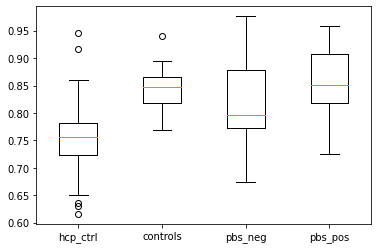

In [18]:
plt.boxplot((dev_test, dev_controls, dev_pbs_neg, dev_pbs_pos),
            labels=('hcp_ctrl','controls', 'pbs_neg', 'pbs_pos'))

In [114]:
F,p_hcp_ctrl = mannwhitneyu(dev_test, dev_controls)
print(p_hcp_ctrl)
F,p_hcp_pbs_neg = mannwhitneyu(dev_test, dev_pbs_neg)
print(p_hcp_pbs_neg)
F,p_hcp_pbs_pos = mannwhitneyu(dev_test, dev_pbs_pos)
print(p_hcp_pbs_pos)
F,p_ctrl_pbs_neg = mannwhitneyu(dev_controls, dev_pbs_neg)
print(p_ctrl_pbs_neg)
F,p_ctrl_pbs_pos = mannwhitneyu(dev_controls, dev_pbs_pos)
print(p_ctrl_pbs_pos)

3.760882626673899e-10
0.0048119312943120385
4.585228155026896e-11
0.08359353264563857
0.2535273608761953


In [116]:
pvalues = np.array([p_hcp_ctrl, p_hcp_pbs_neg, p_hcp_pbs_pos,
                    p_ctrl_pbs_neg, p_ctrl_pbs_pos])
multipletests(pvalues, method='bonferroni')

(array([ True,  True,  True, False, False]),
 array([1.88044131e-09, 2.40596565e-02, 2.29261408e-10, 4.17967663e-01,
        1.00000000e+00]),
 0.010206218313011495,
 0.01)

### Latent space analysis - all data

In [15]:
X_all = np.array(list(deletion_hcp['latent']) + 
                 list(deletion_controls['latent']) + 
                 list(deletion_pbs_sub_neg['latent']) + 
                 list(deletion_pbs_sub_pos['latent']))
labels = np.array(['hcp_test' for k in range(200)] + 
                  ['controls' for k in range(len(deletion_controls))] + 
                  ['pbs_sub_neg' for k in range(len(deletion_pbs_sub_neg))] +
                  ['pbs_sub_pos' for k in range(len(deletion_pbs_sub_pos))])

In [21]:
reducer = umap.UMAP(n_neighbors=35)
embedding = reducer.fit_transform(X_all)

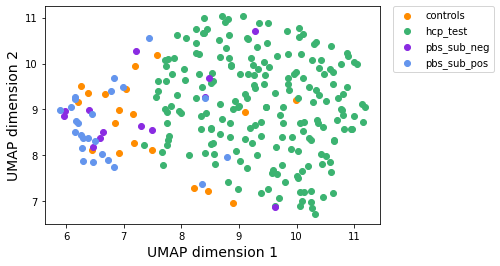

In [22]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'blueviolet','pbs_sub_pos':'cornflowerblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=1)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

# for i, txt in enumerate(list(deletion_ccd_subjects['sub'])):
#         ax.annotate(txt, (embedding[207:][i][0], embedding[207:][i][1]))

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [23]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_all)

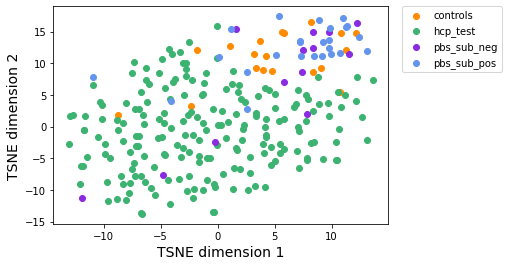

In [24]:
arr = X_embedded
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'blueviolet','pbs_sub_pos':'cornflowerblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'TSNE dimension 1', fontsize=14)
plt.ylabel(f'TSNE dimension 2', fontsize=14)
plt.show()

### Latent space analysis - PBS data

In [55]:
X_pbs = np.array(list(deletion_controls['latent']) 
                 + list(deletion_pbs_sub_neg['latent'])
                 + list(deletion_pbs_sub_pos['latent']))
labels_pbs = np.array(['controls' for k in range(len(deletion_controls))] + 
                      ['pbs_sub_neg' for k in range(len(deletion_pbs_sub_neg))] +
                      ['pbs_sub_pos' for k in range(len(deletion_pbs_sub_pos))])
subjects = np.array(list(deletion_controls['sub']) 
                 + list(deletion_pbs_sub_neg['sub'])
                 + list(deletion_pbs_sub_pos['sub']))

In [26]:
reducer = umap.UMAP(n_neighbors=10)
embedding = reducer.fit_transform(X_pbs)

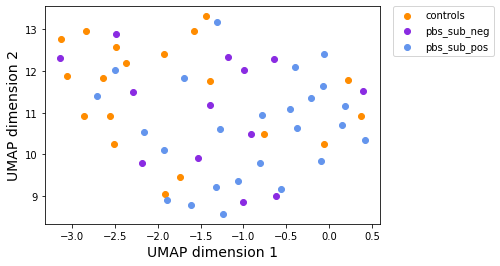

In [27]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'blueviolet','pbs_sub_pos':'cornflowerblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_pbs):
    ix = np.where(labels_pbs == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [28]:
X_embedded = TSNE(n_components=2, perplexity=15, random_state=12).fit_transform(X_pbs)

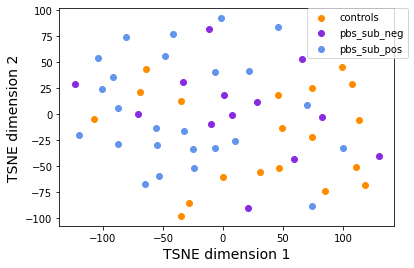

In [29]:
arr = X_embedded
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'blueviolet','pbs_sub_pos':'cornflowerblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_pbs):
    ix = np.where(labels_pbs == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'TSNE dimension 1', fontsize=14)
plt.ylabel(f'TSNE dimension 2', fontsize=14)
plt.show()

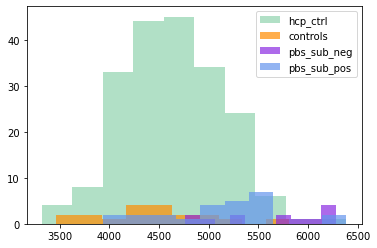

In [72]:
plt.subplot()
plt.hist(deletion_hcp.recon, color='mediumseagreen', alpha=0.4, label='hcp_ctrl',bins=10)
plt.hist(deletion_controls.recon, color='darkorange', alpha=0.7, label='controls', bins=10)
plt.hist(deletion_pbs_sub_neg.recon, color='blueviolet', alpha=0.7, label='pbs_sub_neg', bins=10)
plt.hist(deletion_pbs_sub_pos.recon, color='cornflowerblue', alpha=0.7, label='pbs_sub_pos', bins=10)
plt.legend()

In [30]:
F,p_hcp_ctrl = mannwhitneyu(deletion_hcp.recon, deletion_controls.recon)
print(p_hcp_ctrl)
F,p_ctrl_neg = mannwhitneyu(deletion_controls.recon, deletion_pbs_sub_neg.recon)
print(p_ctrl_neg)
F,p_ctrl_pos = mannwhitneyu(deletion_controls.recon, deletion_pbs_sub_pos.recon)
print(p_ctrl_pos)
F,p_hcp_neg = mannwhitneyu(deletion_hcp.recon, deletion_pbs_sub_neg.recon)
print(p_hcp_neg)
F,p_hcp_pos = mannwhitneyu(deletion_hcp.recon, deletion_pbs_sub_pos.recon)
print(p_hcp_pos)

0.08931497274846256
2.7988515161797e-05
0.0008124292837382617
5.534062727216809e-07
8.149639521309082e-05


In [31]:
#from statsmodels.sandbox.stats.multicomp import multipletests
pvalues = np.array([p_hcp_ctrl, p_ctrl_neg, p_ctrl_pos, p_hcp_neg, p_hcp_pos])
multipletests(pvalues, method='bonferroni')

(array([False,  True,  True,  True,  True]),
 array([4.46574864e-01, 1.39942576e-04, 4.06214642e-03, 2.76703136e-06,
        4.07481976e-04]),
 0.010206218313011495,
 0.01)

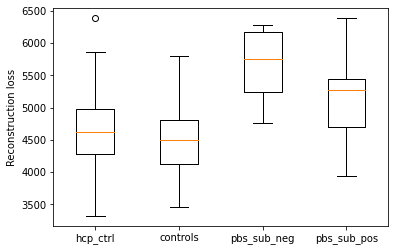

In [32]:
plt.boxplot((deletion_hcp.recon, deletion_controls.recon, deletion_pbs_sub_neg.recon, deletion_pbs_sub_pos.recon),
            labels=('hcp_ctrl','controls','pbs_sub_neg', 'pbs_sub_pos'))
plt.ylabel('Reconstruction loss')
#plt.ylim(1500,5500)
plt.rcParams['axes.grid'] = False

### Distributions of latent dimensions

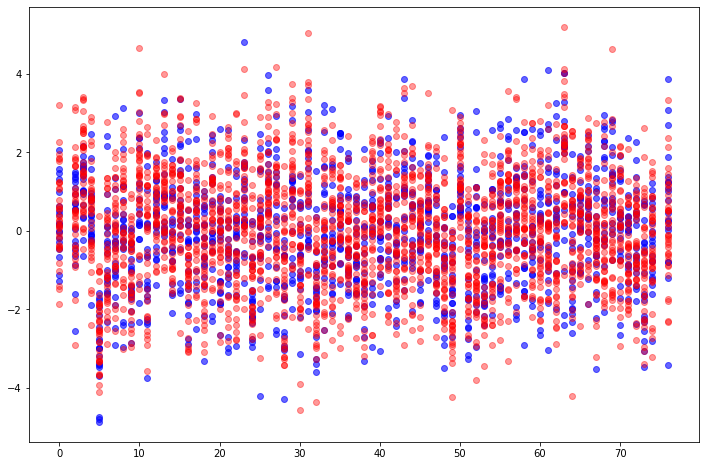

In [33]:
fig = plt.figure(figsize=(12,8))
for i in range(75):
    x = [i+i%3 for k in range(len(df_encoded[df_encoded.group=='controls']))]
    x_sub_neg = [i+i%3 for k in range(len(df_encoded[df_encoded.group=='pbs_sub_neg']))]
    x_sub_pos = [i+i%3 for k in range(len(df_encoded[df_encoded.group=='pbs_sub_pos']))]
    plt.scatter(x, [df_encoded[df_encoded.group=='controls'].latent[k][i] for k in df_encoded[df_encoded.group=='controls'].index], c='b', alpha=0.6)
    plt.scatter(x_sub_neg, [df_encoded[df_encoded.group=='pbs_sub_neg'].latent[k][i] for k in df_encoded[df_encoded.group=='pbs_sub_neg'].index], c='r', alpha=0.4)
    plt.scatter(x_sub_pos, [df_encoded[df_encoded.group=='pbs_sub_pos'].latent[k][i] for k in df_encoded[df_encoded.group=='pbs_sub_pos'].index], c='r', alpha=0.4)

## Focus on subjects with a PBS

In [34]:
pbs_list = [('pbs_sub_neg','sujet08'), ('pbs_sub_neg','sujet10'), ('pbs_sub_neg','sujet12'), 
            ('pbs_sub_neg','sujet22'),('pbs_sub_neg','sujet23'), ('pbs_sub_neg','sujet15'),
            ('pbs_sub_pos', 'sujet07'), ('pbs_sub_pos', 'sujet08'), ('pbs_sub_pos', 'sujet13'), 
            ('pbs_sub_pos', 'sujet36'), ('pbs_sub_pos', 'sujet34'), ('pbs_sub_pos', 'sujet38'), 
            ('pbs_sub_pos', 'sujet41'), ('controls','control07')]

In [35]:
df_encoded['pbs'] = [False for k in range(len(df_encoded))]

for k in range(200, len(df_encoded)):
    for group, sub in pbs_list:
        if (df_encoded['sub'][k] == sub) & (df_encoded['group'][k] == group):
            df_encoded['pbs'][k] = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
reducer = umap.UMAP(n_neighbors=35, random_state=12)
embedding = reducer.fit_transform(X_pbs)
pbs = np.array(df_encoded.pbs[200:])

In [56]:
marker = ['x' if pbs[k] else 'o' for k in range(len(pbs))]
color = [color_dict[group] for group in labels_pbs]
x = np.array([embedding[k][0] for k in range(len(embedding))])
y = np.array([embedding[k][1] for k in range(len(embedding))])

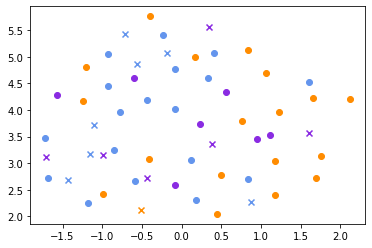

In [57]:
for m, c, _x, _y in zip(marker, color, x, y):
    plt.scatter(_x, _y, marker=m, c=c)

#### With HCP test data

In [58]:
reducer = umap.UMAP(n_neighbors=35, random_state=12)
embedding = reducer.fit_transform(X_all)
pbs = np.array(df_encoded.pbs)

In [61]:
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'blueviolet','pbs_sub_pos':'cornflowerblue'}

marker = ['x' if pbs[k] else 'o' for k in range(len(pbs))]
color = [color_dict[group] for group in labels]
x = np.array([embedding[k][0] for k in range(len(embedding))])
y = np.array([embedding[k][1] for k in range(len(embedding))])

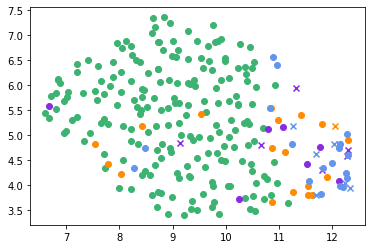

In [62]:
for m, c, _x, _y in zip(marker, color, x, y):
    plt.scatter(_x, _y, marker=m, c=c)

In [63]:
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X_pbs)
labels_pbs = np.array(df_encoded.pbs[200:])

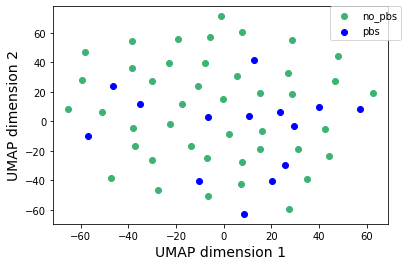

In [64]:
arr = X_embedded
color_dict = {False:'mediumseagreen', True:'blue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_pbs):
    ix = np.where(labels_pbs == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g:
        g_lab= "pbs"
    else:
        g_lab = "no_pbs"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
# for i, txt in enumerate(list(deletion_ccd_subjects['sub'])):
#         ax.annotate(txt, (embedding[207:][i][0], embedding[207:][i][1]))

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [65]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_pbs)

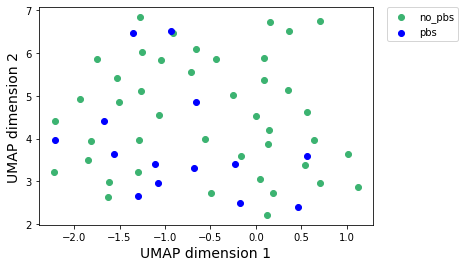

In [66]:
arr = embedding
color_dict = {False:'mediumseagreen', True:'blue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_pbs):
    ix = np.where(labels_pbs == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g:
        g_lab= "pbs"
    else:
        g_lab = "no_pbs"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
# for i, txt in enumerate(list(deletion_ccd_subjects['sub'])):
#         ax.annotate(txt, (embedding[207:][i][0], embedding[207:][i][1]))

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

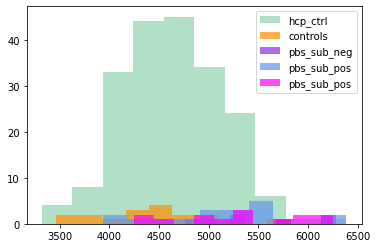

In [74]:
plt.subplot()
plt.hist(df_encoded[(df_encoded.pbs==False) & (df_encoded.group=='hcp_test')].recon, color='mediumseagreen', alpha=0.4, label='hcp_ctrl',bins=10)
plt.hist(df_encoded[(df_encoded.pbs==False) & (df_encoded.group=='controls')].recon, color='darkorange', alpha=0.7, label='controls', bins=10)
plt.hist(df_encoded[(df_encoded.pbs==False) & (df_encoded.group=='pbs_sub_neg')].recon, color='blueviolet', alpha=0.7, label='pbs_sub_neg', bins=10)
plt.hist(df_encoded[(df_encoded.pbs==False) & (df_encoded.group=='pbs_sub_pos')].recon, color='cornflowerblue', alpha=0.7, label='pbs_sub_pos', bins=10)
plt.hist(df_encoded[(df_encoded.pbs==True)].recon, color='magenta', alpha=0.7, label='pbs_sub_pos', bins=10)
plt.legend()

In [68]:
hcp = df_encoded[(df_encoded.pbs==False) & (df_encoded.group=='hcp_test')].recon
controls = df_encoded[(df_encoded.pbs==False) & (df_encoded.group=='controls')].recon
pbs_neg = df_encoded[(df_encoded.pbs==False) & (df_encoded.group=='pbs_sub_neg')].recon
pbs_pos = df_encoded[(df_encoded.pbs==False) & (df_encoded.group=='pbs_sub_pos')].recon
pbs = df_encoded[(df_encoded.pbs==True)].recon

In [69]:
F,p_ctrl_pbs = mannwhitneyu(controls, pbs)
print(p_ctrl_pbs)
F,p_hcp_pbs = mannwhitneyu(hcp, pbs)
print(p_hcp_pbs)
F,p_pbs_neg_pbs = mannwhitneyu(pbs_neg, pbs)
print(p_pbs_neg_pbs)
F,p_pbs_pos_pbs = mannwhitneyu(pbs_pos, pbs)
print(p_pbs_pos_pbs)

0.0011132712827884633
0.00023625519371046094
0.34078344639723834
0.2908821517084704


In [70]:
pvalues = np.array([p_hcp_ctrl, p_ctrl_neg, p_ctrl_pos, p_hcp_neg, p_hcp_pos, p_ctrl_pbs, p_hcp_pbs, 
                    p_pbs_neg_pbs, p_pbs_pos_pbs])
multipletests(pvalues, method='bonferroni')

(array([False,  True,  True,  True,  True,  True,  True, False, False]),
 array([8.03834755e-01, 2.51896636e-04, 7.31186355e-03, 4.98065645e-06,
        7.33467557e-04, 1.00194415e-02, 2.12629674e-03, 1.00000000e+00,
        1.00000000e+00]),
 0.005683044988048058,
 0.005555555555555556)

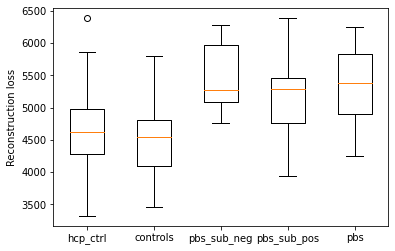

In [71]:
plt.boxplot((hcp, controls, pbs_neg, pbs_pos, pbs),
            labels=('hcp_ctrl','controls','pbs_sub_neg', 'pbs_sub_pos', 'pbs'))
plt.ylabel('Reconstruction loss')
#plt.ylim(1500,5500)
plt.rcParams['axes.grid'] = False

In [71]:
df_encoded[200:].sort_values(by='recon', ascending=False)

,latent,loss,recon,input,sub,group
235,"[-1.4757527, -0.92527175, -0.3692636, 0.475404...",10369,10052,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet05,pbs_sub_pos
222,"[0.17533799, 0.095984094, 0.082480736, 0.96319...",6720,6404,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet08,pbs_sub_neg
228,"[1.2394698, 0.73551553, 0.77991873, 2.5421038,...",6642,6323,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet20,pbs_sub_neg
223,"[1.2394214, -0.37019187, 0.82962143, 2.1459541...",6525,6186,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet10,pbs_sub_neg
233,"[0.60199434, 0.3710033, -0.6587182, 2.5008311,...",6518,6184,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet03,pbs_sub_pos
225,"[-0.38711444, -0.7033296, 1.7791798, 2.159376,...",6515,6182,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet13,pbs_sub_neg
230,"[-0.13480605, -0.42999968, 1.0937973, 3.417509...",6434,6071,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet23,pbs_sub_neg
229,"[1.7924198, 0.12013081, -1.5882704, 1.4530994,...",6268,5887,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet22,pbs_sub_neg
231,"[0.27831423, 0.53221357, -0.38282874, 3.362724...",6033,5744,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet26,pbs_sub_neg
224,"[-0.34977633, -0.5908157, 1.323921, 0.6808693,...",5948,5631,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,sujet12,pbs_sub_neg


# Average Patterns

In [142]:
controls = df_encoded[df_encoded.group=='controls'].latent
pbs_neg = df_encoded[df_encoded.group=='pbs_sub_neg'].latent
pbs_pos = df_encoded[df_encoded.group=='pbs_sub_pos'].latent

In [143]:
enc_ctrl = np.array([np.mean([controls[k][i] for k in controls.index]) for i in range(75)])
enc_neg = np.array([np.mean([pbs_neg[k][i] for k in pbs_neg.index]) for i in range(75)])
enc_pos = np.array([np.mean([pbs_pos[k][i] for k in pbs_pos.index]) for i in range(75)])

In [84]:
tgt_dir = '/neurospin/dico/lguillon/distmap/PBS/results/'

In [144]:
z = torch.from_numpy(np.array(enc_ctrl)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.35] = 1
out[out<=0.35] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}ctrl_bucket.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}ctrl_mesh.mesh")

In [145]:
z = torch.from_numpy(np.array(enc_neg)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.35] = 1
out[out<=0.35] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}pbs_neg_bucket.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}pbs_neg_mesh.mesh")

In [146]:
z = torch.from_numpy(np.array(enc_pos)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.35] = 1
out[out<=0.35] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}pbs_pos_bucket.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}pbs_pos_mesh.mesh")

### Without left handers

In [147]:
list_leftH_pos = ['sujet05', 'sujet07', 'sujet11', 'sujet13', 'sujet03', 'sujet14', 'sujet15','sujet35']

In [148]:
pbs_pos = df_encoded[(df_encoded.group=='pbs_sub_pos')]
pbs_pos['handedness'] = ['left' if sub in list_leftH_pos else 'right' for sub in pbs_pos['sub']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [149]:
controls = df_encoded[df_encoded.group=='controls'].latent
pbs_neg = df_encoded[(df_encoded.group=='pbs_sub_neg')&(df_encoded.sub!='sujet03')].latent
pbs_pos = pbs_pos[pbs_pos['handedness']=='right'].latent

In [151]:
enc_pos = np.array([np.mean([pbs_pos[k][i] for k in pbs_pos.index]) for i in range(75)])

z = torch.from_numpy(np.array(enc_pos)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.35] = 1
out[out<=0.35] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}pbs_pos_bucket.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}pbs_pos_mesh.mesh")

### Reconstruction

In [13]:
df_encoded.head()

,latent,loss,recon,input,sub,group
0,"[0.30990145, -1.8776301, 1.8489814, 0.3253556,...",5265,4907,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,932554,hcp_test
1,"[2.9290807, 2.2934983, 0.7623368, 1.893309, -0...",4908,4562,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,387959,hcp_test
2,"[0.28676105, 2.0780075, 1.4219029, 2.0806706, ...",5155,4812,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,887373,hcp_test
3,"[-1.0776975, -0.3607143, 2.0666773, 1.0325136,...",5631,5332,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,704238,hcp_test
4,"[-0.00579176, 1.7885638, 3.1161547, 0.34614325...",4797,4444,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,169040,hcp_test


In [20]:
tgt_dir = "/neurospin/dico/lguillon/distmap/PBS/results/"

for k in range(len(df_encoded)):
    if df_encoded.pbs[k]==True:
        enc = df_encoded.latent[k]
        sub = df_encoded['sub'][k]
        input_pbs = np.squeeze(df_encoded['input'][k])
        z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
        z = torch.unsqueeze(z, dim=0)
        out = model.decode(z)
        out = np.array(np.squeeze(out).cpu().detach().numpy())

        error = input_pbs - out
        error2 = out - input_pbs

        error[error>0.4] = 1
        error[error<=0.4] = 0
        error2[error2>0.4] = 1
        error2[error2<=0.4] = 0
        input_pbs[input_pbs>0.4] = 1
        input_pbs[input_pbs<=0.4] = 0
        out[out>0.4] = 1
        out[out<=0.4] = 0

        aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error)), 
                f"{tgt_dir}{sub}_error_missing.mesh")
        aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error2)), 
                   f"{tgt_dir}{sub}_error_adding.mesh")
        aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(input_pbs)), 
                f"{tgt_dir}{sub}_input.mesh")
        aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
                   f"{tgt_dir}{sub}_out.mesh")

In [18]:
input_data = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

In [155]:
len(input_data['ccd_subjects'])

7

In [161]:
tgt_dir = "/neurospin/dico/lguillon/distmap/CCD/results/"

for k in range(len(deletion_ccd_subjects)):
    enc = deletion_ccd_subjects.latent[k]
    input_ccd = np.squeeze(input_data['ccd_subjects'][k])
    sub = deletion_ccd_subjects['sub'][k]
    
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    
    error = input_ccd - out
    error2 = out - input_ccd

    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error)), 
            f"{tgt_dir}{sub}_error_missing.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error2)), 
               f"{tgt_dir}{sub}_error_adding.mesh")

### Reconstruction of controls

In [22]:
tgt_dir = "/neurospin/dico/lguillon/distmap/CCD/results/"

for k in range(3):
    enc = deletion_controls.latent[k]
    input_ctrl = np.squeeze(input_data['controls'][k])
    sub = deletion_controls['sub'][k]
    
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    
    error = input_ctrl - out
    error2 = out - input_ctrl

    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    out[out>0.4] = 1
    out[out<=0.4] = 0
    input_ctrl[input_ctrl>0.4] = 1
    input_ctrl[input_ctrl<=0.4] = 0
    
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error)), 
            f"{tgt_dir}{sub}_error_missing.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error2)), 
               f"{tgt_dir}{sub}_error_adding.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(input_ctrl)), 
            f"{tgt_dir}{sub}_input.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
               f"{tgt_dir}{sub}_recon.mesh")